In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [32]:
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

In [ ]:
metadatos

In [ ]:
#Una forma de mostrar 5 ejemplos del set
tfds.as_dataframe(datos['train'].take(5), metadatos)

2024-06-26 16:59:17.090352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


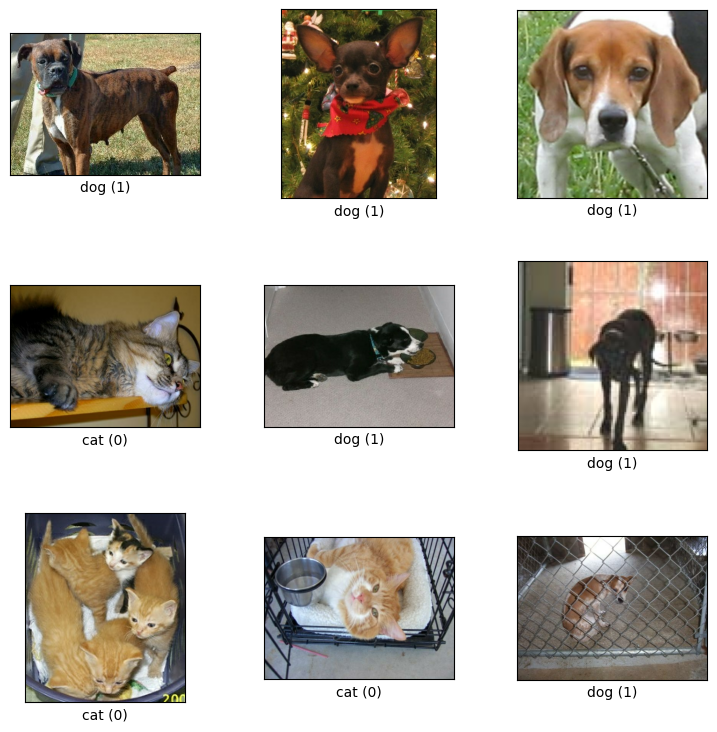

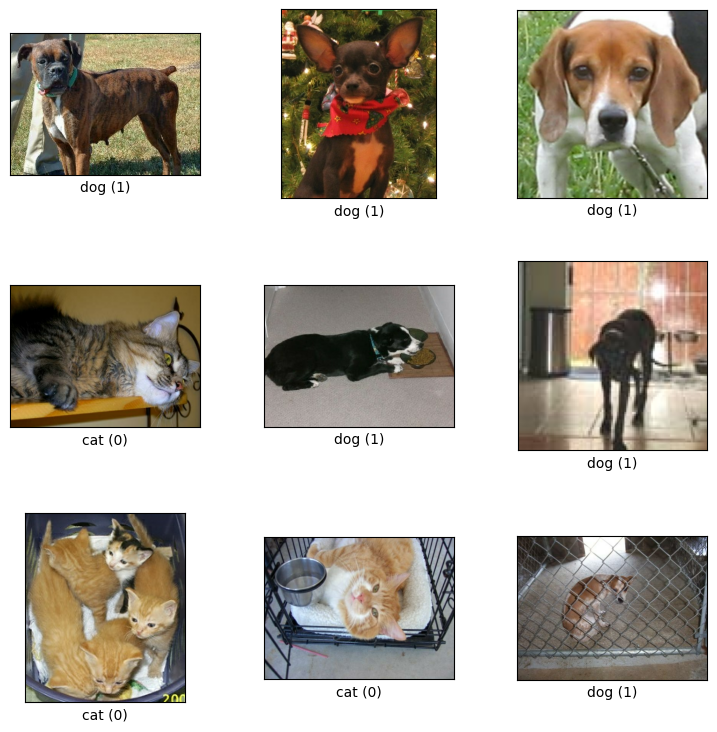

In [36]:
#Otra forma de mostrar ejemplos del set
tfds.show_examples(datos['train'], metadatos)

In [11]:
!pip list | grep opencv-python


opencv-python                 4.10.0.84

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


2024-06-26 16:48:18.929959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


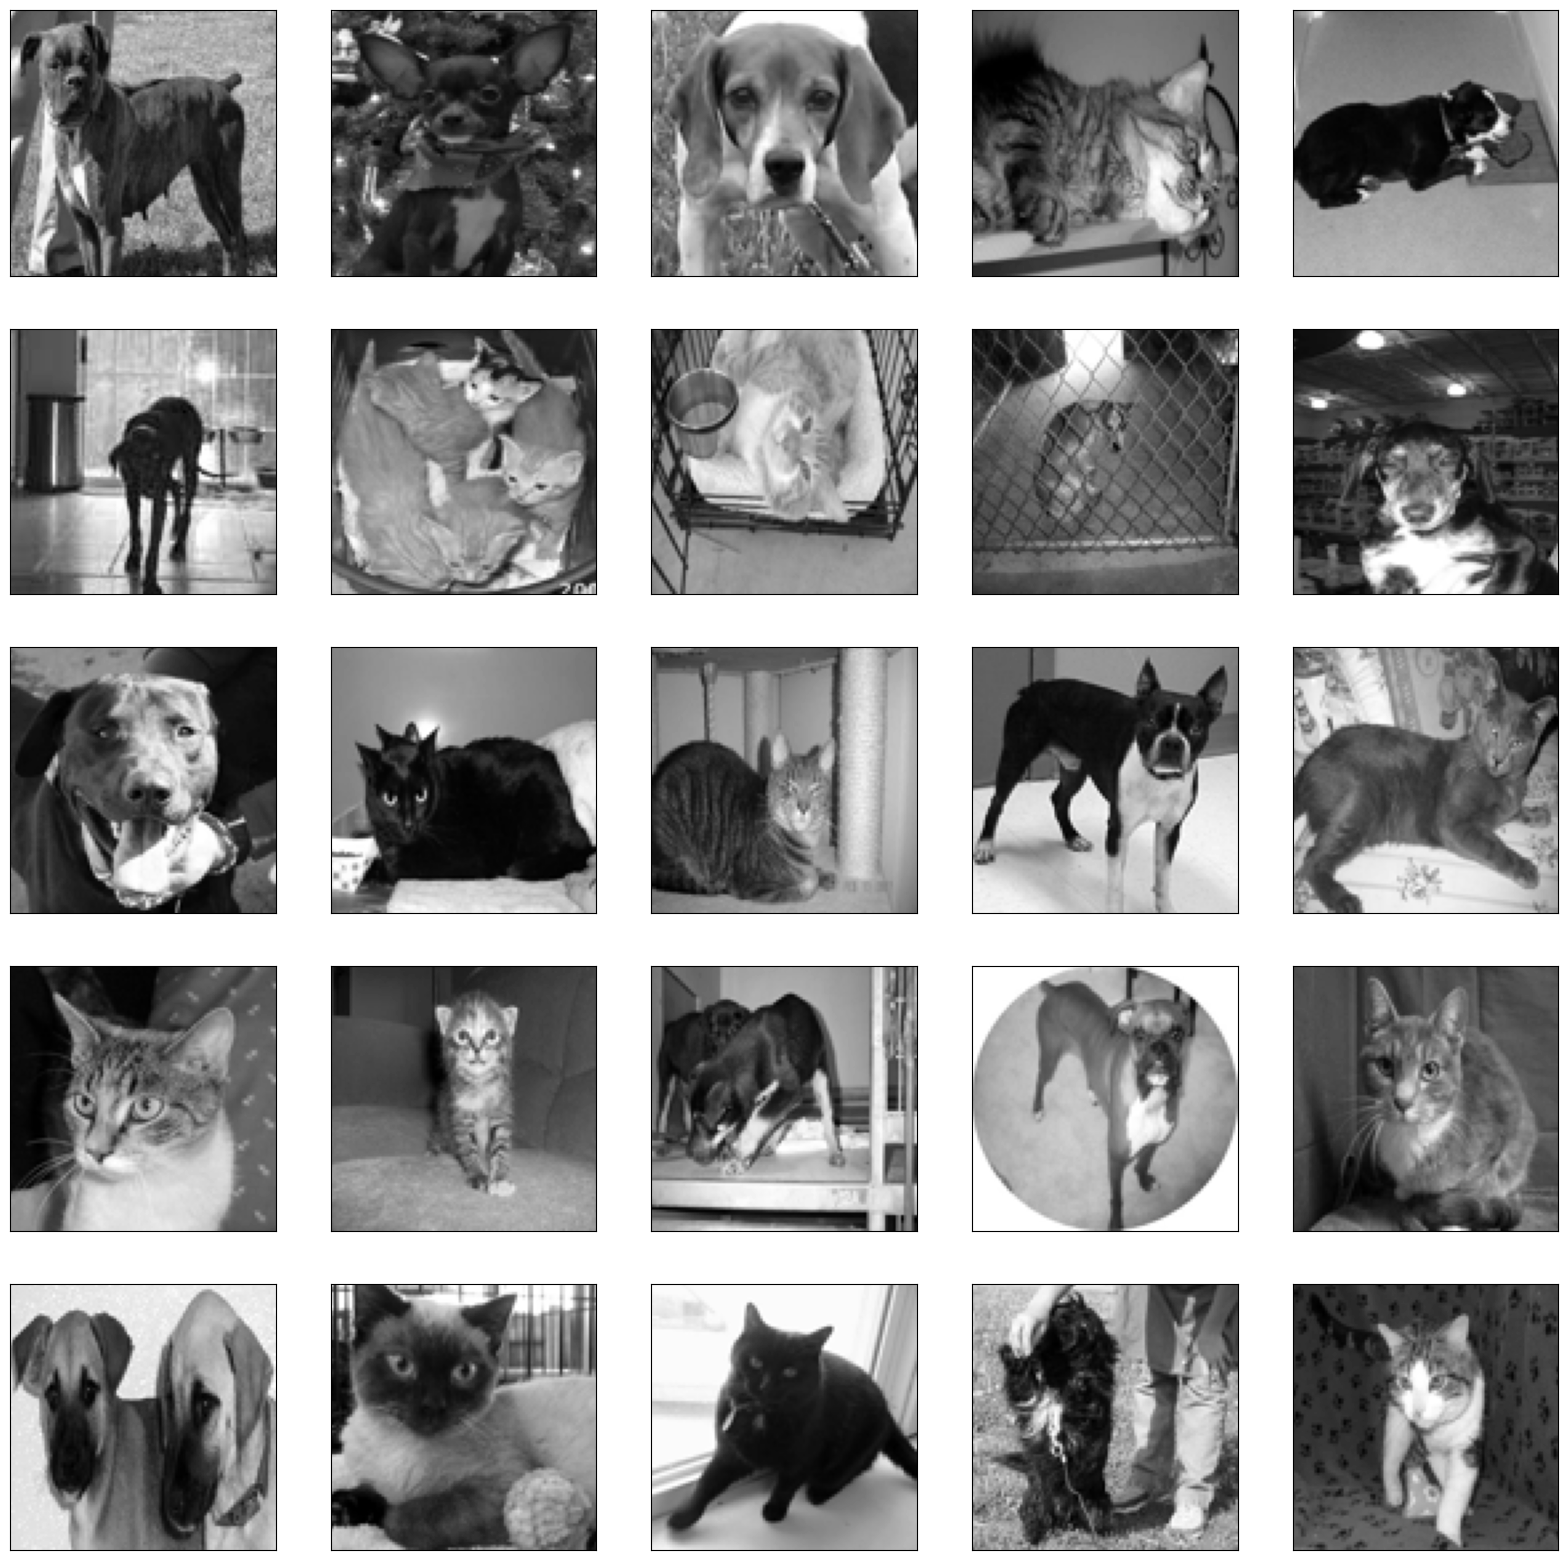

In [17]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
    imagen = imagen.numpy()
    imagen = Image.fromarray(imagen)
    imagen = imagen.resize((TAMANO_IMG, TAMANO_IMG)).convert('L')
    imagen = np.array(imagen)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen, cmap='gray')

In [37]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

In [38]:
for i, (imagen, etiqueta) in enumerate(datos['train']):  # Todos los datos
    imagen = imagen.numpy()
    imagen = Image.fromarray(imagen)
    imagen = imagen.resize((TAMANO_IMG, TAMANO_IMG)).convert('L')
    imagen = np.array(imagen)
    imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1)  # Cambiar tamaño a 100,100,1
    datos_entrenamiento.append([imagen, etiqueta])

2024-06-26 17:04:39.297218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
datos_entrenamiento[0]

In [40]:
#Ver cuantos datos tengo en la variable
len(datos_entrenamiento)

23262

In [41]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [ ]:
X

In [42]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [43]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [44]:
X.shape

(23262, 100, 100, 1)

In [45]:
#Crear los modelos iniciales
#Usan sigmoid como salida (en lugar de softmax) para mostrar como podria funcionar con dicha funcion de activacion.
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
#Compilar modelos. Usar crossentropy binario ya que tenemos solo 2 opciones (perro o gato)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [51]:
from tensorflow.keras.callbacks import TensorBoard

#La variable de tensorboard se envia en el arreglo de "callbacks" (hay otros tipos de callbacks soportados)
#En este caso guarda datos en la carpeta indicada en cada epoca, de manera que despues
#Tensorboard los lee para hacer graficas
tensorboardDenso = TensorBoard(log_dir='./logs/denso')
modeloDenso.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=10,
                callbacks=[tensorboardDenso])

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6149 - loss: 0.6523 - val_accuracy: 0.6100 - val_loss: 0.6599
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6231 - loss: 0.6485 - val_accuracy: 0.6089 - val_loss: 0.6614
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6193 - loss: 0.6484 - val_accuracy: 0.6054 - val_loss: 0.6652
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6233 - loss: 0.6456 - val_accuracy: 0.5794 - val_loss: 0.6735
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6253 - loss: 0.6497 - val_accuracy: 0.6140 - val_loss: 0.6584
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6175 - loss: 0.6475 - val_accuracy: 0.5908 - val_loss: 0.6702
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6264 - loss: 0.6441 - val_accuracy: 0.6146 - val_loss: 0.6566
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6245 - loss: 0.6425 - val_accuracy: 0

In [52]:
%load_ext tensorboard

In [54]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=10,
                callbacks=[tensorboardCNN])

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.9452 - loss: 0.1408 - val_accuracy: 0.8258 - val_loss: 0.4479
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.9678 - loss: 0.0884 - val_accuracy: 0.8361 - val_loss: 0.4785
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.9776 - loss: 0.0613 - val_accuracy: 0.8284 - val_loss: 0.5968
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.9882 - loss: 0.0373 - val_accuracy: 0.8287 - val_loss: 0.8115
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.9842 - loss: 0.0467 - val_accuracy: 0.8309 - val_loss: 0.7761
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.9929 - loss: 0.0245 - val_accuracy: 0.8344 - val_loss: 0.8122
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9909 - loss: 0.0280 - val_accuracy: 0.8178 - val_loss: 0.8985
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9920 - loss: 0.0256 - 

In [56]:
tensorboardCNN2 = TensorBoard(log_dir='logs/cnn2')
modeloCNN2.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=10,
                callbacks=[tensorboardCNN2])

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.7664 - loss: 0.4803 - val_accuracy: 0.7642 - val_loss: 0.4868
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.8037 - loss: 0.4233 - val_accuracy: 0.8089 - val_loss: 0.4126
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.8362 - loss: 0.3643 - val_accuracy: 0.8249 - val_loss: 0.3940
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8512 - loss: 0.3379 - val_accuracy: 0.8418 - val_loss: 0.3571
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8752 - loss: 0.2880 - val_accuracy: 0.8530 - val_loss: 0.3461
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 79s 86ms/step - accuracy: 0.8931 - loss: 0.2581 - val_accuracy: 0.8436 - val_loss: 0.3580
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.9084 - loss: 0.2215 - val_accuracy: 0.8559 - val_loss: 0.3363
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.9236 - loss: 0.1890 - 

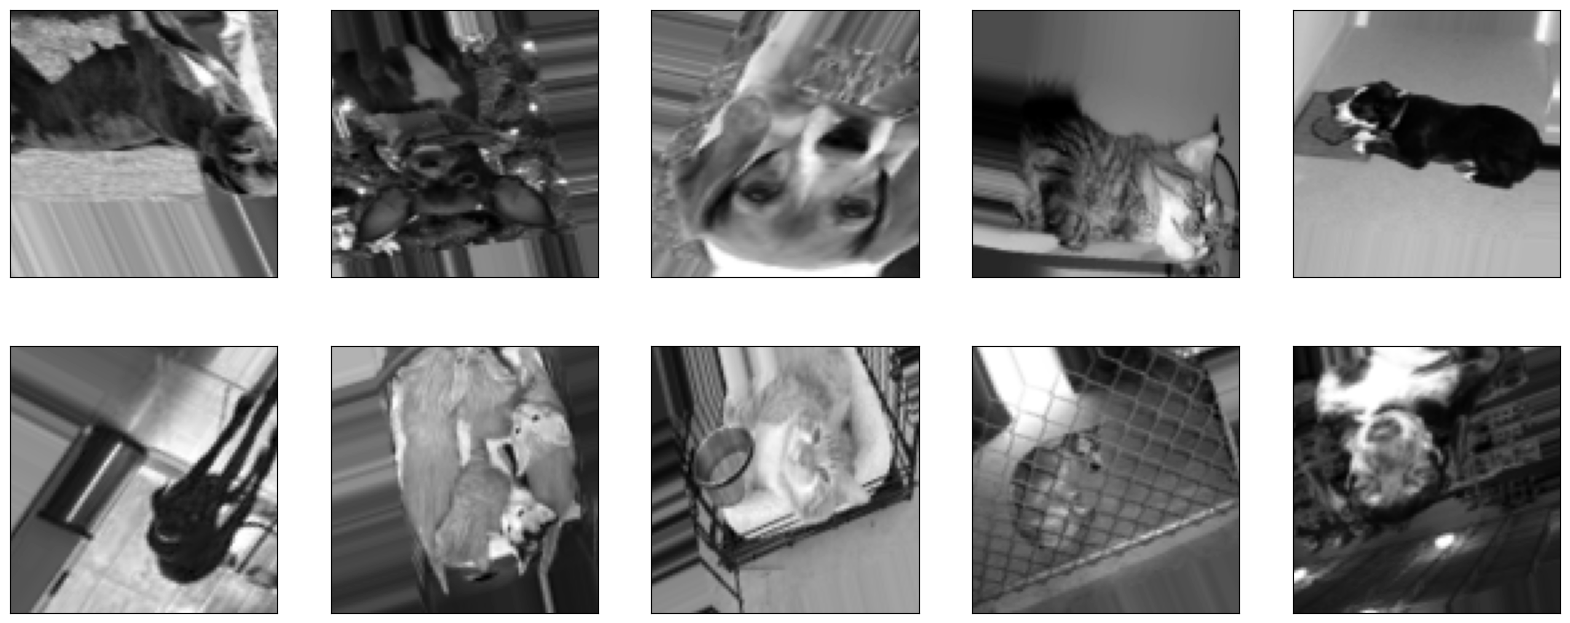

In [57]:
#Realizar el aumento de datos con varias transformaciones. Al final, graficar 10 como ejemplo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i].reshape(100, 100), cmap="gray")
  break

In [ ]:
modeloDenso_AD = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activatie=15,
    zoom_rangeon='sigmoid')
])

modeloCNN2_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloDenso_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
#Separar los datos de entrenamiento y los datos de pruebas en variables diferentes

len(X) * .85 #19700
len(X) - 19700 #3562

X_entrenamiento = X[:19700]
X_validacion = X[19700:]

y_entrenamiento = y[:19700]
y_validacion = y[19700:]

In [ ]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
data_gen_entrenamiento = datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32)

In [ ]:
tensorboardDenso_AD = TensorBoard(log_dir='logs/denso_AD')

modeloDenso_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardDenso_AD]
)

In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs-new/cnn_AD')

modeloCNN_AD.fit(
    data_gen_entrenamiento,
    epochs=150, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN_AD]
)

In [ ]:
tensorboardCNN2_AD = TensorBoard(log_dir='logs/cnn2_AD')

modeloCNN2_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN2_AD]
)

In [ ]:
# modeloCNN_AD.save('perros-gatos-cnn-ad.h5')